In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672570703000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 * 24

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

              Close_Time     Open    Close     High      Low      Volume
0    2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542
1    2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365
2    2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490
3    2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584
4    2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134
..                   ...      ...      ...      ...      ...         ...
949  2023-03-21 12:59:59  1746.14  1750.15  1754.17  1745.32  12164.4816
950  2023-03-21 13:59:59  1750.15  1740.43  1750.16  1736.30  18470.8951
951  2023-03-21 14:59:59  1740.44  1738.83  1746.45  1733.99  15043.0321
952  2023-03-21 15:59:59  1738.83  1730.34  1740.48  1717.01  33202.3433
953  2023-03-21 16:59:59  1730.34  1730.87  1733.92  1725.00   8441.3464

[954 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

              Close_Time     Open    Close     High      Low      Volume  \
0    2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542   
1    2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365   
2    2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490   
3    2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584   
4    2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134   
..                   ...      ...      ...      ...      ...         ...   
949  2023-03-21 12:59:59  1746.14  1750.15  1754.17  1745.32  12164.4816   
950  2023-03-21 13:59:59  1750.15  1740.43  1750.16  1736.30  18470.8951   
951  2023-03-21 14:59:59  1740.44  1738.83  1746.45  1733.99  15043.0321   
952  2023-03-21 15:59:59  1738.83  1730.34  1740.48  1717.01  33202.3433   
953  2023-03-21 16:59:59  1730.34  1730.87  1733.92  1725.00   8441.3464   

           ema_8       ema_14       ema_50        atr      slowk      slowd  \
0       

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] >= df['ema_50']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,atr,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2023-01-01 19:59:59,1197.14,1196.34,1197.41,1195.72,2854.0542,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
1,2023-01-01 20:59:59,1196.35,1197.17,1198.50,1195.83,4418.7365,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 21:59:59,1197.16,1195.26,1197.29,1193.54,4804.4490,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 22:59:59,1195.26,1194.50,1195.86,1194.20,3496.2584,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 23:59:59,1194.50,1196.81,1196.81,1194.34,2771.4134,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,2023-03-21 12:59:59,1746.14,1750.15,1754.17,1745.32,12164.4816,1749.570182,1752.988568,1765.146351,17.638267,50.538600,46.140771,True,True,True,False,False,False,False
950,2023-03-21 13:59:59,1750.15,1740.43,1750.16,1736.30,18470.8951,1747.539031,1751.314092,1764.177082,17.368391,39.313140,44.397019,False,False,False,False,False,False,False
951,2023-03-21 14:59:59,1740.44,1738.83,1746.45,1733.99,15043.0321,1745.603690,1749.649547,1763.183079,17.017791,37.144118,42.331953,False,False,False,False,False,False,False
952,2023-03-21 15:59:59,1738.83,1730.34,1740.48,1717.01,33202.3433,1742.211759,1747.074941,1761.895115,17.478664,26.500994,34.319417,False,False,False,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']


for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price
        # set stop loss
        # 進場
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'take_profit'] = close_val.shift(1).at[index] + 2 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        buydf.at[index, 'status'] = 'Pending'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    
for index, row in buydf.iterrows():
    # Check if the jth row's status is 'Pending'
    if df.loc[index, 'status'] == 'Pending':
        for j in range(index, len(buydf)):
            if df.loc[j, 'High'] >= df.loc[index, 'take_profit']:
                # If the price is higher, calculate the profit
                profit = df.loc[index, 'take_profit'] - df.loc[index, 'entry_p']
                # Set the 'Status' column in the jth row to 'Sold'
                df.loc[index, 'status'] = 'Sell'
                # Set the 'take_profit' column in the jth row to the calculated profit
                df.loc[index, 'profit'] = profit
                break

            if df.loc[j, 'Close'] <= df.loc[index, 'stop_loss']:
                profit = df.loc[index, 'stop_loss'] - df.loc[index, 'entry_p']
                df.loc[index, 'status'] = 'Stop'
                df.loc[index, 'profit'] = profit
                break
        
for index, row in buydf.iterrows():

    if df.loc[index, 'status'] == 'Pending':
        df.loc[index, 'profit'] = 0

    
buydf.to_csv('buydf.csv')

# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


              Close_Time     Open    Close     High      Low      Volume  \
62   2023-01-04 09:59:59  1213.54  1224.10  1228.85  1213.27  30267.6550   
63   2023-01-04 10:59:59  1224.11  1231.60  1234.50  1224.10  28533.2903   
67   2023-01-04 14:59:59  1248.03  1250.51  1251.97  1247.33  18740.1449   
68   2023-01-04 15:59:59  1250.50  1252.00  1253.13  1247.93  12851.2350   
72   2023-01-04 19:59:59  1249.82  1251.58  1253.72  1249.51   6988.3274   
..                   ...      ...      ...      ...      ...         ...   
912  2023-03-19 23:59:59  1786.21  1793.61  1812.86  1785.20  41124.6870   
915  2023-03-20 02:59:59  1808.66  1822.31  1822.52  1804.90  22563.2799   
916  2023-03-20 03:59:59  1822.32  1821.22  1841.36  1816.84  56545.0641   
919  2023-03-20 06:59:59  1793.64  1804.98  1808.10  1787.30  20367.3410   
920  2023-03-20 07:59:59  1804.99  1780.68  1810.16  1773.98  28740.6947   

           ema_8       ema_14       ema_50        atr  ...    c3    c4  \
62   1214.950

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy')]


col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position', 'entry_p', 'stop_loss', 'take_profit', 'status', 'profit']
pos = posdf[col]
pos = pos.reset_index(drop = True)

        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.03 / 100
entry_amt = pos.entry_p.sum()
SL_amt = pos.loc[pos.status == 'Stop', 'stop_loss'].sum()
TP_amt = pos.loc[pos.status == 'Sell', 'take_profit'].sum()
ttl_fee = (entry_amt + SL_amt + TP_amt) * fee

# 損益
leverage = 10
ttl_profit = pos.profit.sum() - ttl_fee

wins = pos['status'].str.count('Sell').sum()
loses = pos['status'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



             Close_Time     Open    Close     High      Low        atr  \
0   2023-01-04 10:59:59  1224.11  1231.60  1234.50  1224.10   5.033427   
1   2023-01-04 15:59:59  1250.50  1252.00  1253.13  1247.93   5.958925   
2   2023-01-04 20:59:59  1251.59  1250.99  1256.48  1250.77   5.901062   
3   2023-01-04 22:59:59  1253.73  1250.94  1255.18  1249.31   5.713058   
4   2023-01-05 00:59:59  1255.89  1254.02  1257.68  1251.12   6.469117   
..                  ...      ...      ...      ...      ...        ...   
71  2023-03-18 19:59:59  1815.38  1813.15  1816.11  1809.49  18.026432   
72  2023-03-18 21:59:59  1827.30  1815.14  1829.19  1811.80  19.285189   
73  2023-03-19 23:59:59  1786.21  1793.61  1812.86  1785.20  16.736204   
74  2023-03-20 03:59:59  1822.32  1821.22  1841.36  1816.84  18.657912   
75  2023-03-20 07:59:59  1804.99  1780.68  1810.16  1773.98  21.563427   

   position  entry_p    stop_loss  take_profit status     profit  
0       Buy  1224.10  1210.238159  1233.3412

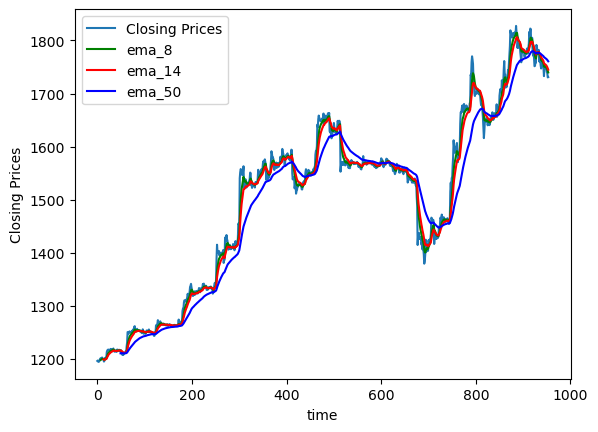

In [13]:
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')

plt.plot(df.ema_8, label='ema_8', c='g')
plt.plot(df.ema_14, label='ema_14', c='r')
plt.plot(df.ema_50, label='ema_50', c='b')
plt.legend()
plt.show()